### Data Generation Stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abc import abstractmethod

np.random.seed(3)

def gen_x(n=100, range=(-5, 5), method="evenly"):
    xmin, xmax = range
    if method.lower() in ["evenly", "even", "e"]:
        return np.linspace(xmin, xmax, n)
    if method.lower() in ["random", "rand", "uniform", "r"]:
        return np.sort(np.random.uniform(xmin, xmax, n))
    else:
        raise ValueError(f"'{method}' is not a valid method. Choose between 'evenly' and 'random'")
    
def split(x, labels):
    x1 = x[np.logical_not(labels)]
    x2 = x[labels]
    return x1, x2

def split_data(data, labels):
    x, y = data
    x1, x2 = split(x, labels)
    y1, y2 = split(y, labels)
    return (x1, y1), (x2, y2)

def gen_y(f, std=0.2):
    return np.random.normal(f, std)

### Labeling Stuff
Classes and methods used for assigning data points to the control or intervention group.

In [2]:
class Labeler:
    """
    Base class for labeling functions.
    
    Different implementations give labels (0 or 1) to the x values passed in __call__,
    depending on the probability defined by the probability density function.
    """
    def __init__(self):
        self.x = None
    
    def density_func(self, x):
        self.x = x
    
    def __call__(self, x):
        return np.random.binomial(1, self.density_func(x)).astype(bool)
    
    def plot(self, x=None, y=None):
        x = self.x if x is None else x
        y = [0, 1] if y is None else y
        if x is None:
            raise ValueError("the x values aren't defined.")
        ymin, ymax = min(y), max(y)
        plt.plot(x, (self.density_func(x) - 0.5) * (ymax - ymin) + (ymin + ymax) / 2,
                 label=f"{self.__class__.__name__} density func")


class Step(Labeler):
    """
    Step function labeler.
    """
    def __init__(self, cutoff):
        super().__init__()
        self.cutoff = cutoff
        
    def density_func(self, x):
        super().density_func(x)
        return np.greater(x, self.cutoff)
    

class Logistic(Labeler):
    """
    Logistic labeler.
    """
    def __init__(self, scale=1, mu=0):
        super().__init__()
        self.scale = scale
        self.mu = mu
        
    def density_func(self, x):
        super().density_func(x)
        return 1/(1+np.exp(-(x-self.mu)/self.scale))

### Small Example of How to Label and Split Data

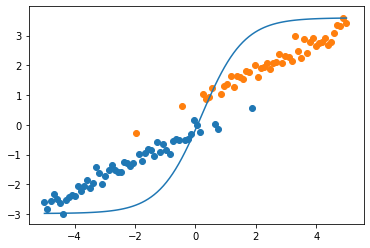

In [3]:
dc = 1
ip = 0.2


x = gen_x(n=100, range=(-5, 5), method="evenly")
labeler = Logistic(scale=0.7, mu=ip)
labels = labeler(x)

f = -0.2 + 0.5 * x  # Linear
#f = 0.8 * np.sin(x) + 0.2 * x ** 2 + 0.2 * np.cos(x / 4)  # Sine + Cosine

y = gen_y(f + dc * labels)

d = (x, y)
d1, d2 = split_data(d, labels)

plt.scatter(*d1)
plt.scatter(*d2)
labeler.plot(x, y)


### Effect Size Estimate Tests


Kernel: linear	|   scale: 100.0
	disc effect size mode
		x mode:
			mean: 0.9599087618522298
			std: 0.33404131573665036
		y mode:
			mean: 0.17434275887420608
			std: 0.003357770534958791
	bma effect size mode
		x mode:
			mean: 0.49083635052026947
			std: 0.5994472364029446
		y mode:
			mean: 0.3492228708454085
			std: 0.2844804830688219
	log bf
		mean: 2.6523213763637012
		std: 3.14397676815302

Kernel: linear	|   scale: 3.0
	disc effect size mode
		x mode:
			mean: 1.0469744167044603
			std: 0.37148790743239823
		y mode:
			mean: 0.19000539057443497
			std: 0.011818611696146302
	bma effect size mode
		x mode:
			mean: 0.957951504603452
			std: 0.5037459992481605
		y mode:
			mean: 0.19773337856238335
			std: 0.03816266295519785
	log bf
		mean: 8.707639846158141
		std: 5.27711136087055

Kernel: linear	|   scale: 1.0
	disc effect size mode
		x mode:
			mean: 1.5569793516815502
			std: 0.48465638735186345
		y mode:
			mean: 0.2721604918966356
			std: 0.03327270239509652
	bma effect s

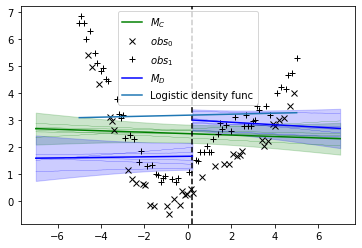

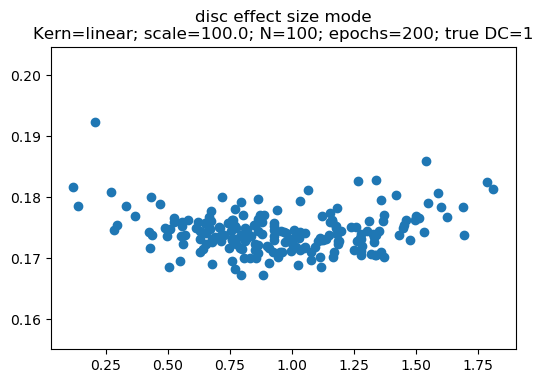

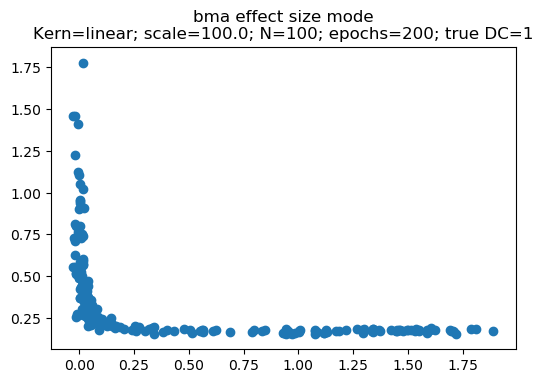

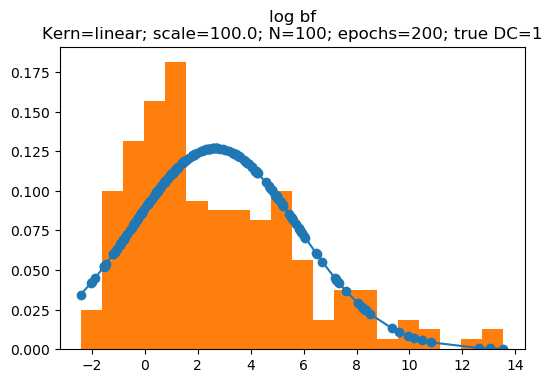

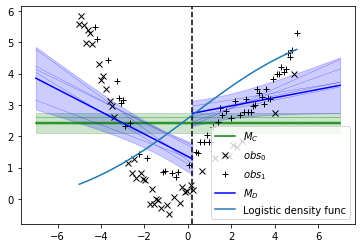

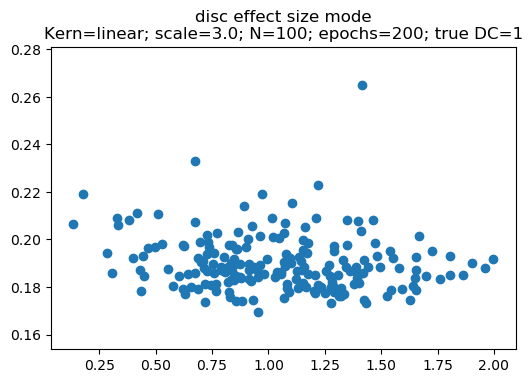

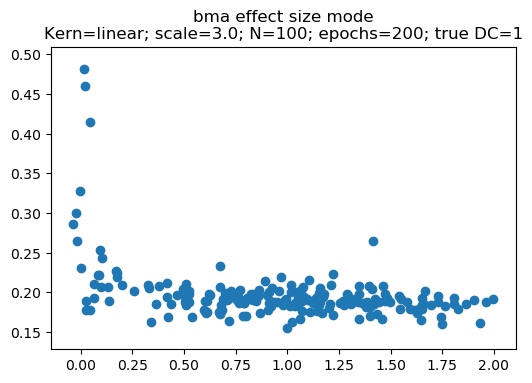

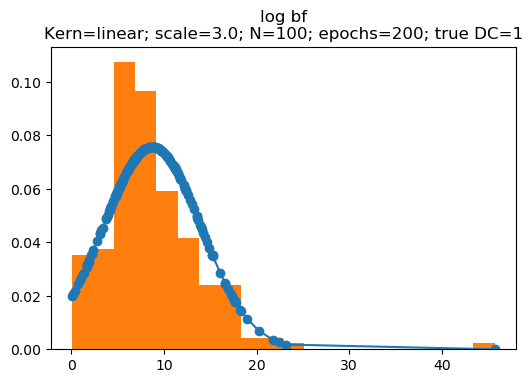

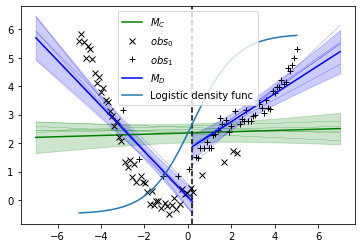

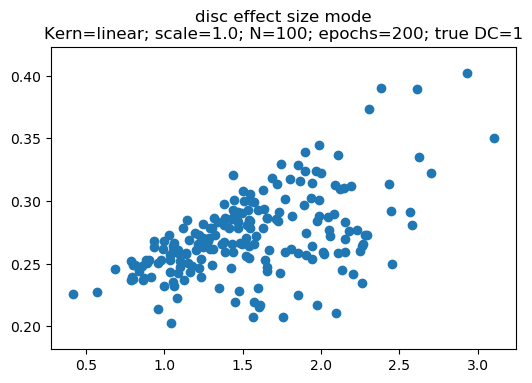

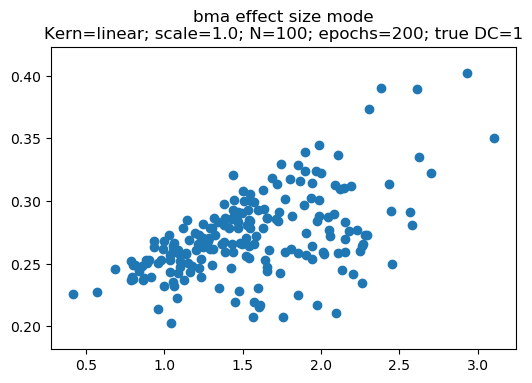

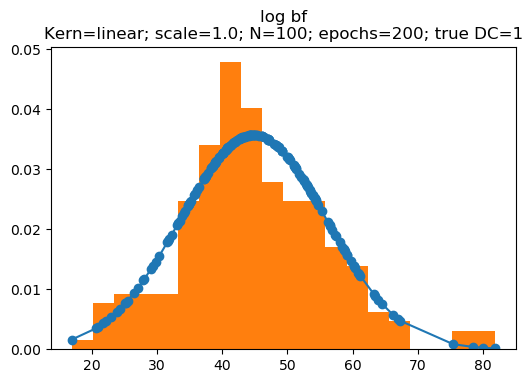

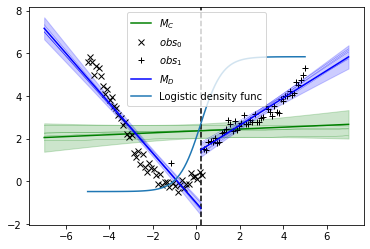

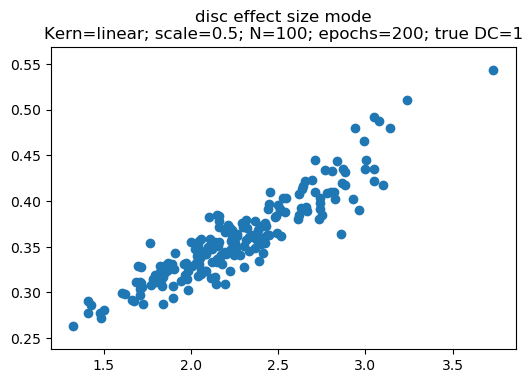

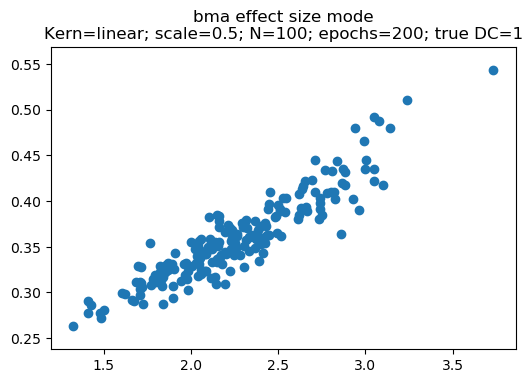

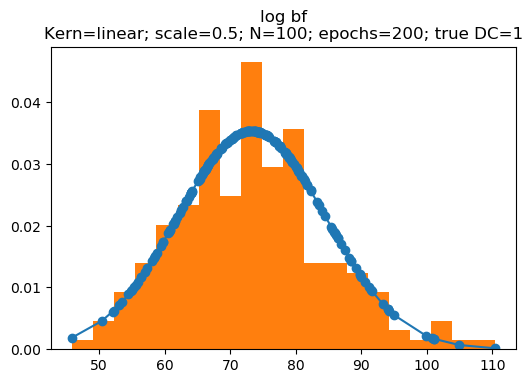

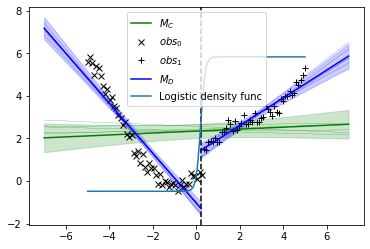

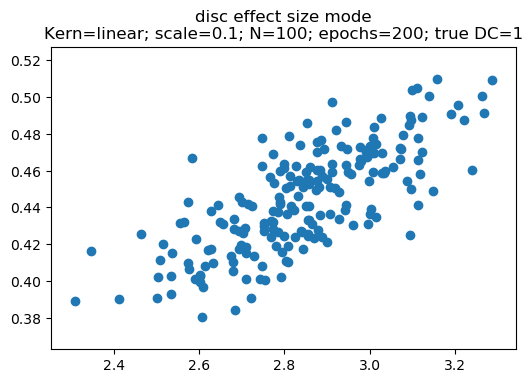

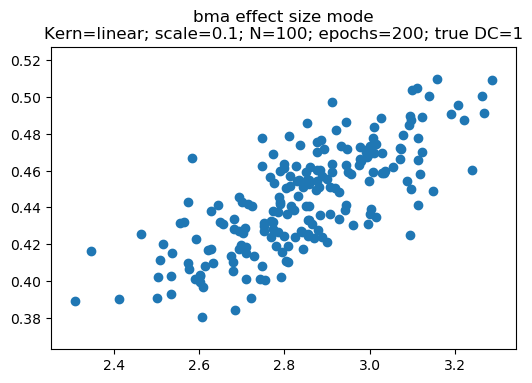

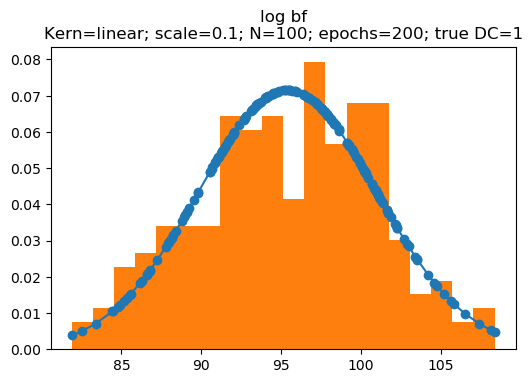

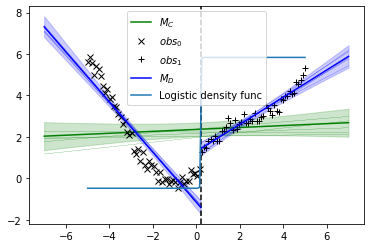

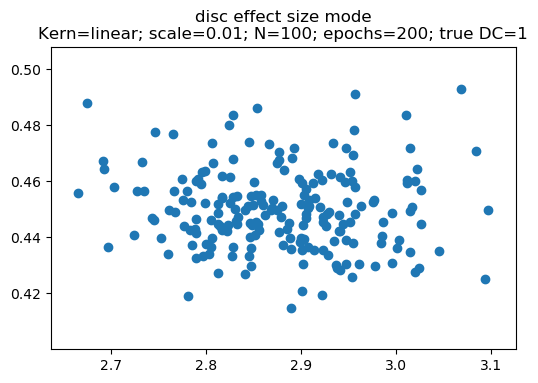

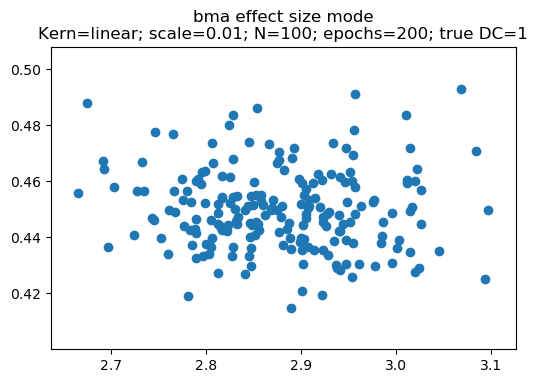

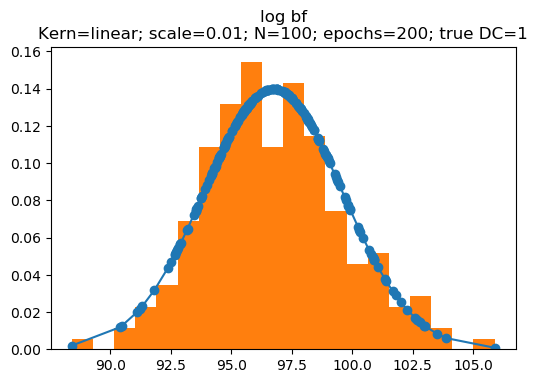

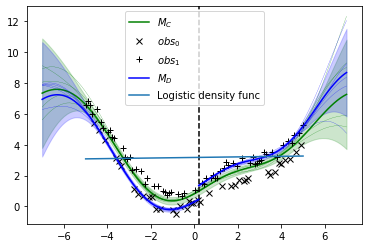

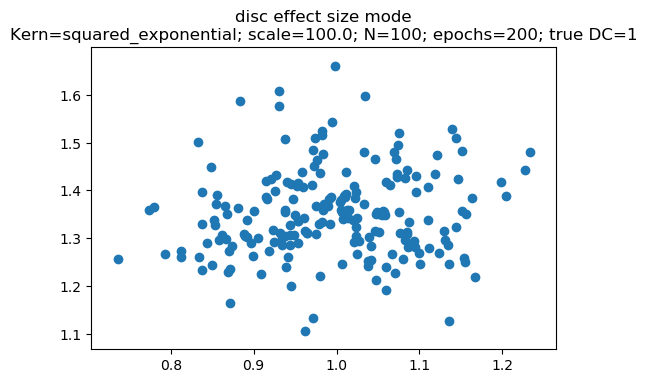

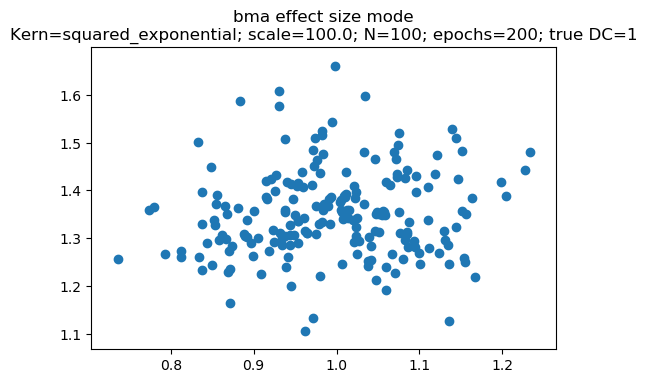

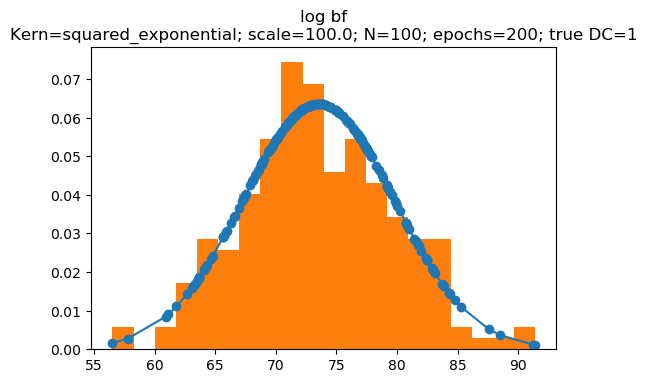

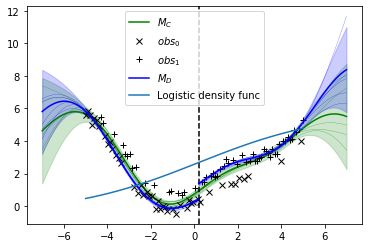

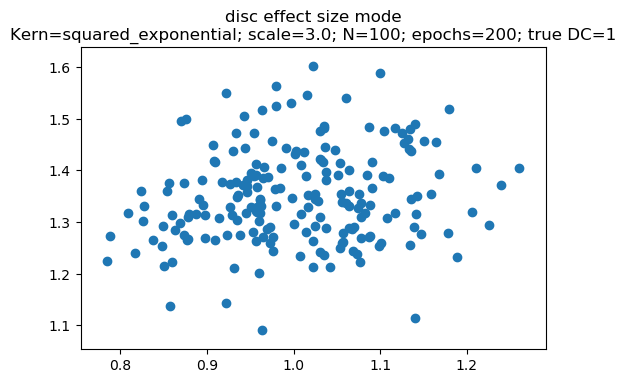

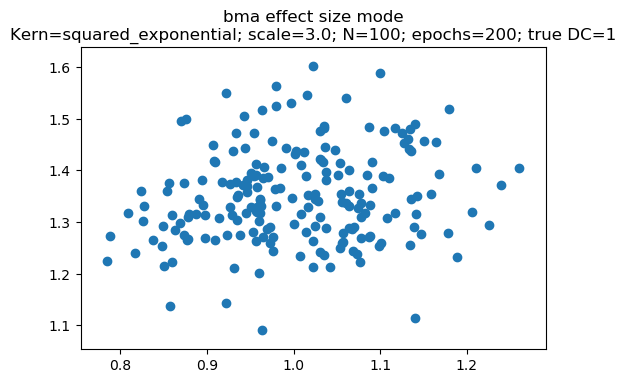

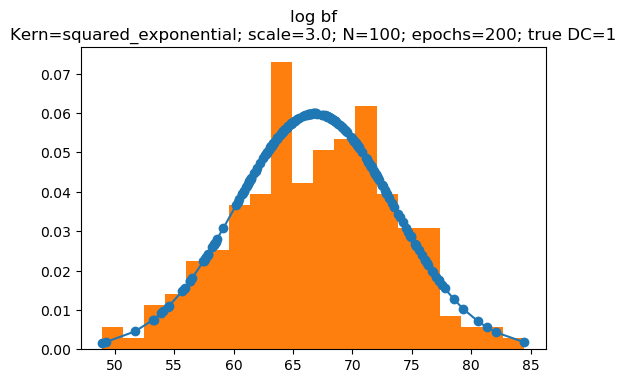

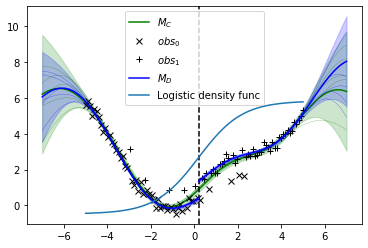

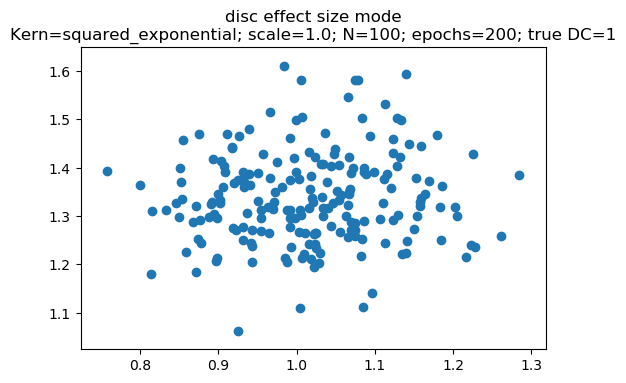

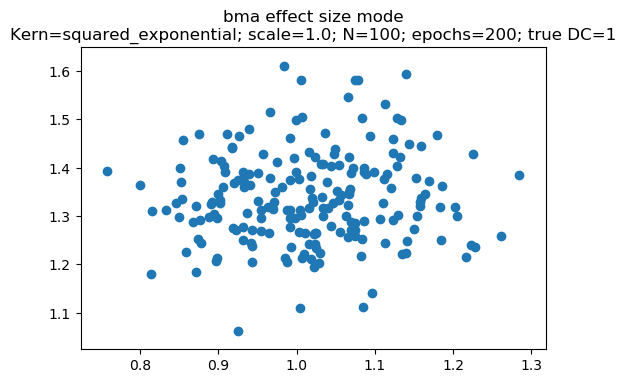

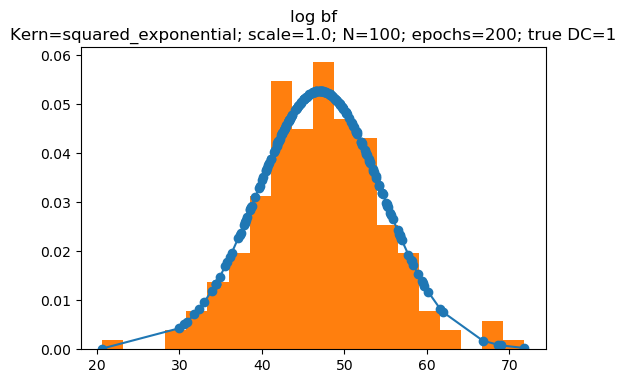

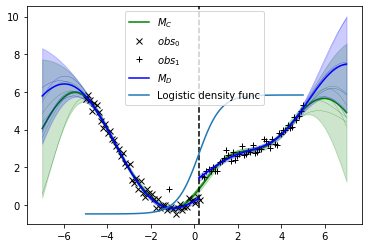

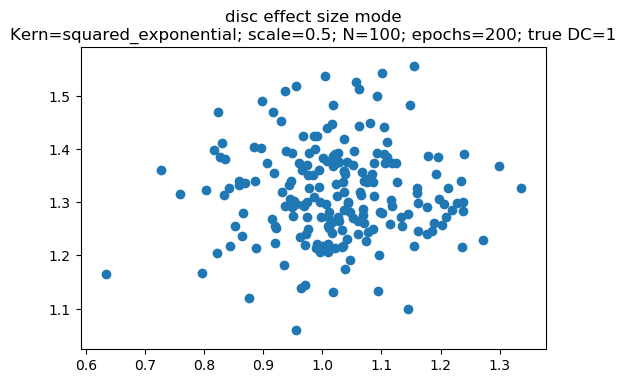

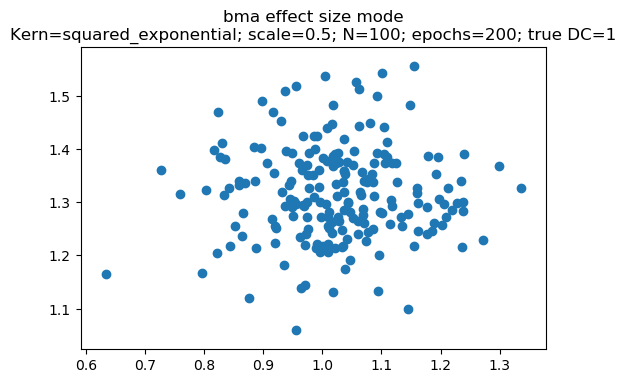

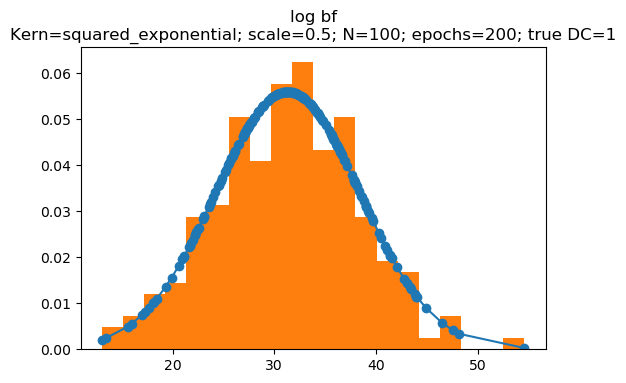

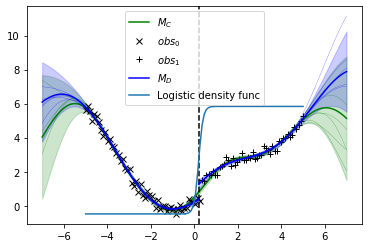

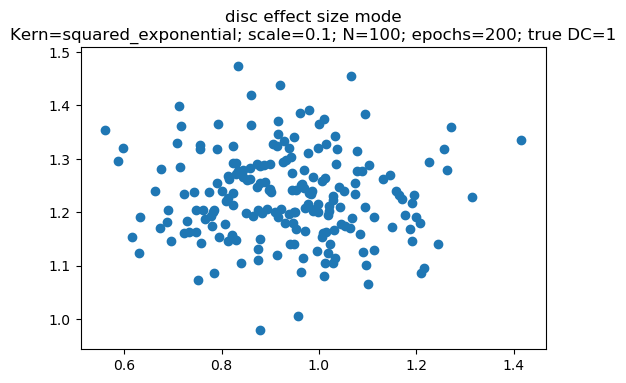

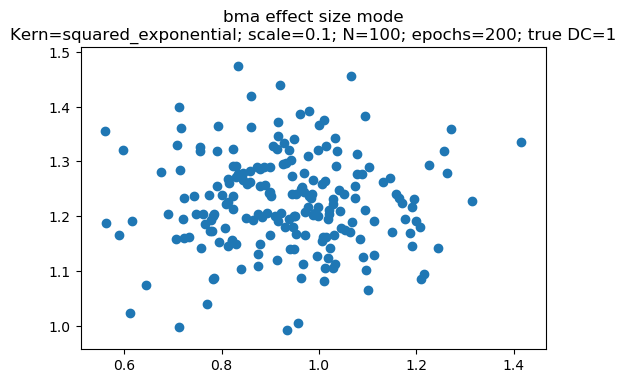

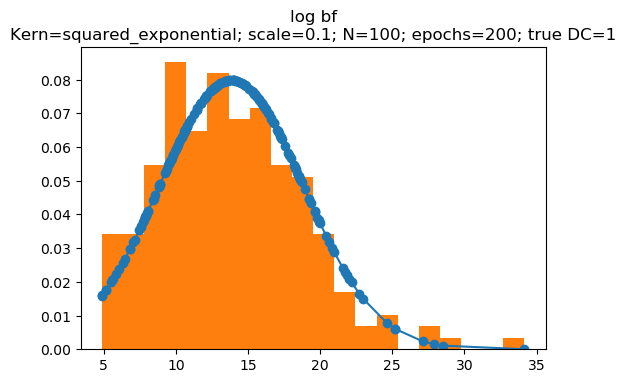

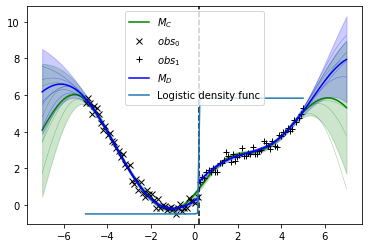

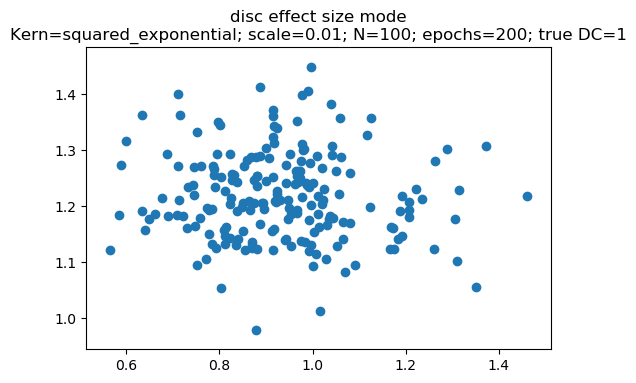

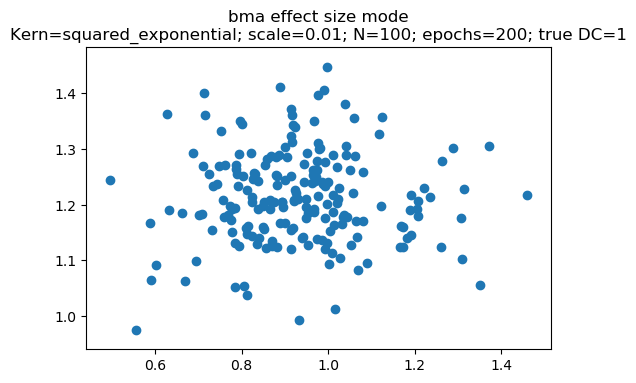

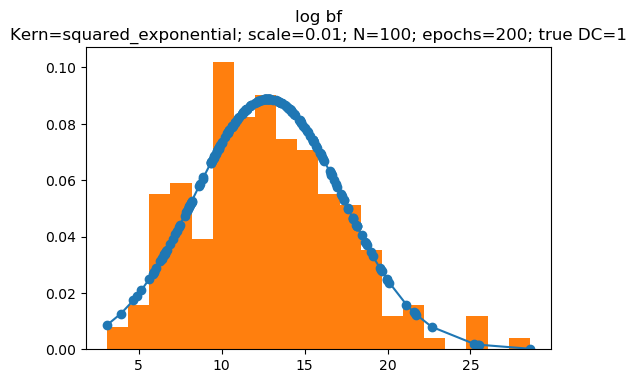

"\n# Some extra plotting stuff I haven't quite figured out yet\n\nfig, ax = plt.subplots(2, 1, dpi=300)\nfor i, (k, v) in enumerate(es_mode_means.items()):\n    curr_ax = \n    (x_mean, x_std), (y_mean, y_std) = v\n    colour = ((i+1)/(len(es_mode_means.items())-1), \n              0.2, \n              1 - (i+1)/(len(es_mode_means.items())-1))\n    confidence_ellipse = Ellipse((x_mean, y_mean), width=2*1.96*x_std, height=2*1.96*y_std, color=colour, alpha=0.5)\n    ax.add_patch(confidence_ellipse)\n    ax.scatter([x_mean], [y_mean], color=colour, label=k)\n    ax.legend()\n"

In [4]:
from bnqdflow.analyses import SimpleAnalysis
from bnqdflow.effect_size_measures import Sharp

from gpflow.kernels import Constant, Linear, RBF, Combination

from itertools import product

from scipy.stats import norm

from matplotlib.patches import Ellipse

dc = 1
ip = 0.2
n_data = 100
x_distr_method = ['evenly', 'random'][0]

#f = -0.2 + 0.5 * x  # Linear
f = 0.8 * np.sin(x) + 0.2 * x ** 2 + 0.2 * np.cos(x / 4)  # Sine + Cosine

scales = [100., 3., 1., .5, .1, .01]
kernels = [
    Linear() + Constant(),
    RBF()
]
show_first_regression_plot = True

epochs = 200

es_mode_means = dict()
log_bf_means = dict()

for kernel, scale in product(kernels, scales):
    
    kern_name = kernel.kernels[0].name if isinstance(kernel, Combination) else kernel.name
    print(f"\nKernel: {kern_name}\t|   scale: {scale}")
    
    res = {
        'disc effect size mode': list(),
        'bma effect size mode': list(),
        'log bf': list()
    }
    
    for epoch in range(epochs):
        
        np.random.seed(epoch)
        
        x = gen_x(n=n_data, range=(-5, 5), method=x_distr_method)
        labeler = Logistic(scale=scale, mu=ip)
        labels = labeler(x)
        
        y = gen_y(f + dc * labels)
        
        d = (x, y)
        d1, d2 = split_data(d, labels)
        
        a = SimpleAnalysis([d1, d2], kernel, ip)
        
        a.train(verbose=False)
        e = a.get_effect_size(Sharp())
        
        if epoch == 0 and show_first_regression_plot:
            plt.figure()
            a.plot_regressions(separate=False)
            labeler.plot(*d)
            plt.legend()
            plt.show()
        
        es_disc = e['es_disc']
        es_bma = e['es_bma']
        es_range = e['es_range']
        
        disc_x_mode = np.argmax(es_disc, axis=0)
        disc_mode = (es_range[disc_x_mode], es_disc[disc_x_mode])
        
        bma_x_mode = np.argmax(es_bma, axis=0)
        bma_mode = (es_range[bma_x_mode], es_bma[bma_x_mode])
        
        res['disc effect size mode'].append(disc_mode)
        res['bma effect size mode'].append(bma_mode)
        res['log bf'].append(a.log_bayes_factor())
    
    for k, v in res.items():
        print(f"\t{k}")
        if k.__contains__("mode"):
            x_vals = list(map(lambda x: x[0], v))
            y_vals = list(map(lambda x: x[1], v))
            mean_x_vals = np.mean(x_vals)
            std_x_vals = np.std(x_vals)
            mean_y_vals = np.mean(y_vals)
            std_y_vals = np.std(y_vals)

            print(f"\t\tx mode:\n"
                  f"\t\t\tmean: {mean_x_vals}\n"
                  f"\t\t\tstd: {std_x_vals}\n"
                  f"\t\ty mode:\n"
                  f"\t\t\tmean: {mean_y_vals}\n"
                  f"\t\t\tstd: {std_y_vals}")
            
            plt.figure(dpi=100)
            plt.title(f"{k}\nKern={kern_name}; scale={scale}; N={n_data}; epochs={epochs}; true DC={dc}")
            plt.scatter(x_vals, y_vals)
            plt.show()

            es_mode_means.update({
                f"{k.split(' ', 1)[0]}; scale={scale}": ((mean_x_vals, std_x_vals), (mean_y_vals, std_y_vals))
            })
        
        else:
            mean_v = np.mean(v)
            std_v = np.std(v)

            print(f"\t\tmean: {mean_v}\n"
                  f"\t\tstd: {std_v}")
                  
            plt.figure(dpi=100)
            v = sorted(v)
            fit = norm.pdf(v, mean_v, std_v)
            plt.title(f"{k}\nKern={kern_name}; scale={scale}; N={n_data}; epochs={epochs}; true DC={dc}")
            plt.plot(v, fit, marker='o')
            plt.hist(v, bins=20, density=1)
            plt.show()

            log_bf_means.update({f"{k.split(' ', 1)[0]}; scale={scale}": (mean_v, std_v)})
            

"""
# Some extra plotting stuff I haven't quite figured out yet

fig, ax = plt.subplots(2, 1, dpi=300)
for i, (k, v) in enumerate(es_mode_means.items()):
    curr_ax = 
    (x_mean, x_std), (y_mean, y_std) = v
    colour = ((i+1)/(len(es_mode_means.items())-1), 
              0.2, 
              1 - (i+1)/(len(es_mode_means.items())-1))
    confidence_ellipse = Ellipse((x_mean, y_mean), width=2*1.96*x_std, height=2*1.96*y_std, color=colour, alpha=0.5)
    ax.add_patch(confidence_ellipse)
    ax.scatter([x_mean], [y_mean], color=colour, label=k)
    ax.legend()
"""

### Testing if the Logistic Labeler Even Works

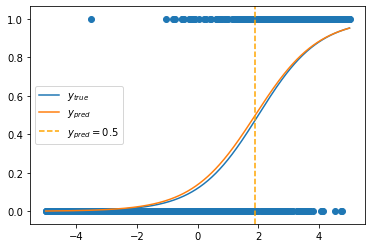

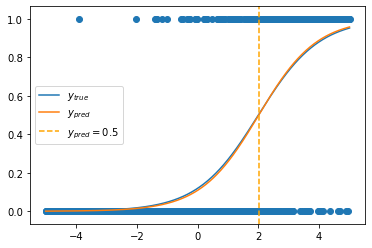

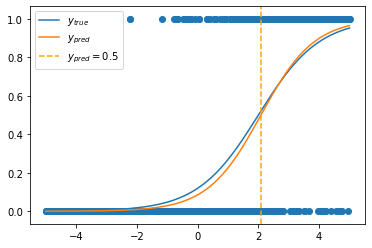

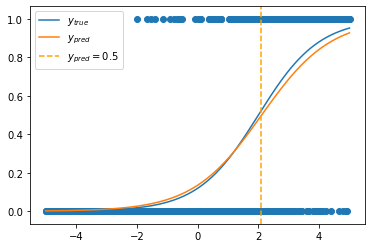

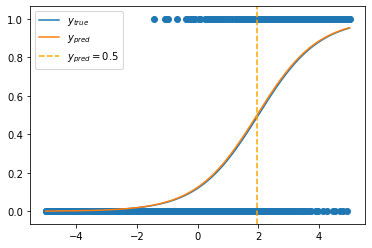

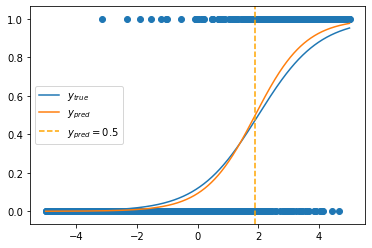

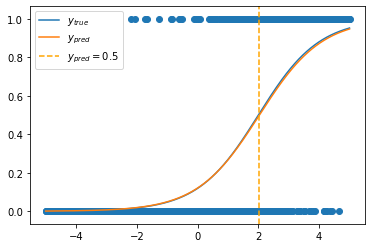

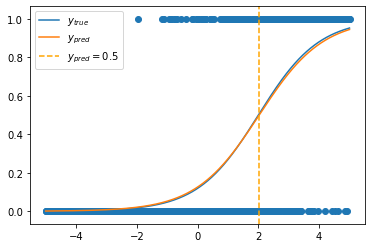

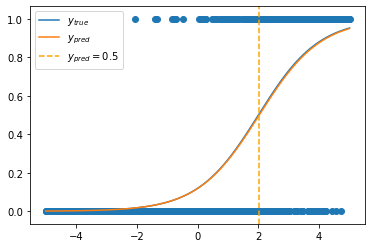

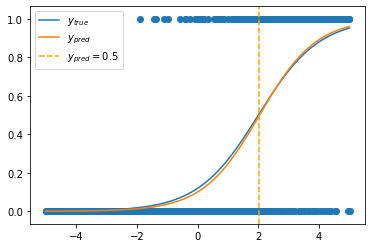

In [4]:
from scipy.optimize import curve_fit

x = gen_x(1000)
scale = 1
offset = 2

l = Logistic(0, 0)

def wrapper(x, scale, offset):
    l.scale = scale
    l.mu = offset
    return l.density_func(x)
    

for seed in range(10):
    np.random.seed(seed)
    l = Logistic(scale, offset)
    y = l(x)
    #np.clip(np.round(np.random.logistic(x - offset, scale)), 0, 1)
    popt, pcov = curve_fit(wrapper, x, y, [1., 0.], method='dogbox')
    plt.scatter(x, y)
    plt.plot(x, Logistic(scale, offset).density_func(x), label="$f_{true}$")
    plt.plot(x, Logistic(*popt).density_func(x), label="$f_{pred}$")
    pred = Logistic(*popt).density_func(x)
    plt.axvline(x[pred <= 0.5][-1], linestyle='--', c='orange', label='$f_{pred}=0.5$')
    plt.legend()
    plt.show()
